In [17]:
import glob
import pandas as pd
import math
import numpy as np
import seaborn as sns
from tqdm import tqdm,trange
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import spacy
from spacy.tokenizer import Tokenizer

import torch
import os
import torch.nn.functional as F
# from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


In [2]:
nlp = spacy.load("en_core_web_sm")
pd.set_option('display.max_colwidth', None)

In [3]:
from transformers import (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer)

/Users/melloo21/opt/anaconda3/envs/cs4248_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Reading all dataset
path = "/Users/melloo21/Desktop/NUS Items/CS4248/2024_CS4248/Project/ImpactCite/ImpactCite_Intent/scicite_data/*.jsonl"
all_scicite = dict()

In [5]:
for g in glob.glob(path):
    name = g.split("/")[-1].split(".")[0]
    all_scicite[name] = pd.read_json(path_or_buf=g, lines=True)   

In [6]:
all_scicite["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8243 entries, 0 to 8242
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source             8243 non-null   object 
 1   citeEnd            8241 non-null   float64
 2   sectionName        8243 non-null   object 
 3   citeStart          8241 non-null   float64
 4   string             8243 non-null   object 
 5   label              8243 non-null   object 
 6   label_confidence   6137 non-null   float64
 7   citingPaperId      8243 non-null   object 
 8   citedPaperId       8243 non-null   object 
 9   isKeyCitation      8243 non-null   bool   
 10  id                 8243 non-null   object 
 11  unique_id          8243 non-null   object 
 12  excerpt_index      8243 non-null   int64  
 13  label2             835 non-null    object 
 14  label2_confidence  317 non-null    float64
dtypes: bool(1), float64(4), int64(1), object(9)
memory usage: 909.8+ KB


In [7]:
all_scicite["train"].describe()

,citeEnd,citeStart,label_confidence,excerpt_index,label2_confidence
count,8241.000000,8241.000000,6137.000000,8243.000000,317.000000
mean,163.965781,139.709744,0.876606,2.333495,0.741582
std,121.478095,79.479383,0.144244,3.326236,0.191581
min,3.000000,0.000000,0.600000,0.000000,0.249800
25%,103.000000,87.000000,0.744700,0.000000,0.616900
50%,152.000000,134.000000,1.000000,1.000000,0.738500
75%,208.000000,187.000000,1.000000,3.000000,1.000000
max,3305.000000,1184.000000,1.000000,19.000000,1.000000


<Axes: xlabel='count', ylabel='label'>

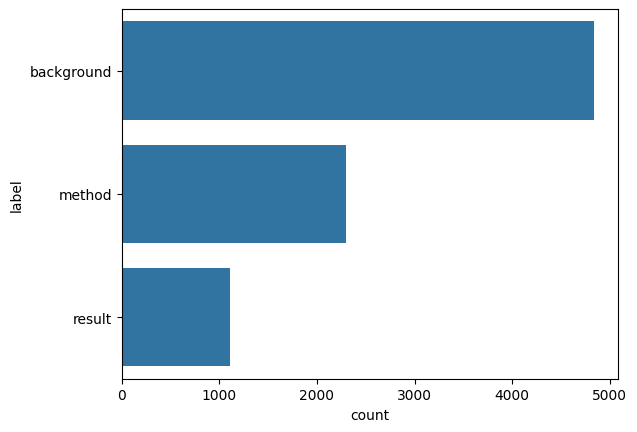

In [18]:
sns.countplot(all_scicite["train"]["label"])

### Example of Citation input
{"source": "explicit", 

"citeEnd": 175, 

"sectionName": "Introduction",

"citeStart": 168, 

"string": "However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as 

direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).",

"label": "background", 

"label_confidence": 1.0,

"citingPaperId": "1872080baa7d30ec8fb87be9a65358cd3a7fb649", 

"citedPaperId": "894be9b4ea46a5c422e81ef3c241072d4c73fdc0", 

"isKeyCitation": true, 

"id": "1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be9b4ea46a5c422e81ef3c241072d4c73fdc0", 

"unique_id": "1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be9b4ea46a5c422e81ef3c241072d4c73fdc0_11",

"excerpt_index": 11
}


## Citation Classes

Background information - The citation states, mentions, or points to the background
information giving more context about a problem, concept,
approach, topic, or importance of the problem in the field.

EXAMPLES: Recent evidence suggests that co-occurring alexithymia may explain deficits [12].
Locally high-temperature melting regions can act as permanent termination sites [6-9].
One line of work is focused on changing the objective function (Mao et al., 2016).

Method - Making use of a method, tool, approach or dataset

EXAMPLES: Fold differences were calculated by a mathematical model described in [4].
We use Orthogonal Initialization (Saxe et al., 2014)

Result comparison - Comparison of the paper’s results/findings with the
results/findings of other work

EXAMPLES: Weighted measurements were superior to T2-weighted contrast imaging which was in
accordance with former studies [25-27]
Similar results to our study were reported in the study of Lee et al (2010).


## Data preprocessing

In [8]:
all_scicite["train"].columns

Index(['source', 'citeEnd', 'sectionName', 'citeStart', 'string', 'label',
       'label_confidence', 'citingPaperId', 'citedPaperId', 'isKeyCitation',
       'id', 'unique_id', 'excerpt_index', 'label2', 'label2_confidence'],
      dtype='object')

In [9]:
all_scicite["train"].groupby(['citingPaperId', 'citedPaperId'],as_index=False).size()

,citingPaperId,citedPaperId,size
0,000549bb992125eecace11190d748278e53696ce,f6461aca4c7e239191580e0b59c5d4c93fd67b87,1
1,000d8d128bc8b44b25970374b4ac274b83e5cfc1,d610bcbd3f209564b658758dfa2be77a4517d658,2
2,000ea376d16a73c3efdafc53068b95cc67ebc3ae,74533ebddadaaceb98d3bef47a919c515575b7f6,1
3,0010f312c554ae9586ef06a888ab56495bc37e17,5453aa977626eb6b4bb5dd31ed274a4e1d983c03,1
4,0012294b23155a9bc58c1b0c367111d7ef94798a,a643c7684944633c3c5b63d72316bf87d7f9a2f6,4
...,...,...,...
4686,ffbf501638a71327a4814a864a5ce4d2a52a42cd,ff025a7e007ee07a19d5cbfdaa26afb94aa08b92,1
4687,ffda3e25293d09832e8a6e7b1378b1670af725b2,de5d6cbd75278792715b53a57b73910d69d0abc8,5
4688,ffdddf8a39bd1b0dd65cfb0e090ee6337d5b2350,9714062de869e00c2ab31289b049b2f21c11e5fd,3
4689,ffe3fc22a46718e6f702bbc13b87c3ff41c923fe,e403aa22bfa9b8c451749218c3670c25add6a027,2


In [14]:
citingPaperId_ref = "ffda3e25293d09832e8a6e7b1378b1670af725b2"
citedPaperId_ref = "de5d6cbd75278792715b53a57b73910d69d0abc8"
all_scicite["train"][(all_scicite["train"].citingPaperId == citingPaperId_ref) 
            & (all_scicite["train"].citedPaperId == citedPaperId_ref)]

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
433,explicit,269.0,INTRODUCTION,247.0,"…of contractile stress fibers (SFs), transmembrane actin-associated (TAN) lines on the dorsal cell surface that position the nucleus, filopodia at the leading edge, isotropic cortical actin networks, and actin important for mitochondrial fission (Skau and Waterman 2015; Campellone and Welch 2010).",background,1.0,ffda3e25293d09832e8a6e7b1378b1670af725b2,de5d6cbd75278792715b53a57b73910d69d0abc8,True,ffda3e25293d09832e8a6e7b1378b1670af725b2>de5d6cbd75278792715b53a57b73910d69d0abc8,ffda3e25293d09832e8a6e7b1378b1670af725b2>de5d6cbd75278792715b53a57b73910d69d0abc8_1,1,NaN,NaN
1506,explicit,161.0,DISCUSSION,137.0,The regulation and localization of actin nucleation factors are likely critical for specifying the function of actin structures in cells (Skau and Waterman 2015).,background,1.0,ffda3e25293d09832e8a6e7b1378b1670af725b2,de5d6cbd75278792715b53a57b73910d69d0abc8,True,ffda3e25293d09832e8a6e7b1378b1670af725b2>de5d6cbd75278792715b53a57b73910d69d0abc8,ffda3e25293d09832e8a6e7b1378b1670af725b2>de5d6cbd75278792715b53a57b73910d69d0abc8_0,0,NaN,NaN
4641,explicit,331.0,INTRODUCTION,280.0,"Specific formins mediate formation of contractile stress fibers (SFs), transmembrane actin-associated (TAN) lines on the dorsal cell surface that position the nucleus, filopodia at the leading edge, isotropic cortical actin networks, and actin important for mitochondrial fission (Skau and Waterman 2015; Campellone and Welch 2010).",background,1.0,ffda3e25293d09832e8a6e7b1378b1670af725b2,de5d6cbd75278792715b53a57b73910d69d0abc8,True,ffda3e25293d09832e8a6e7b1378b1670af725b2>de5d6cbd75278792715b53a57b73910d69d0abc8,ffda3e25293d09832e8a6e7b1378b1670af725b2>de5d6cbd75278792715b53a57b73910d69d0abc8_2,2,NaN,NaN
5244,explicit,292.0,DISCUSSION,270.0,"…Actin to Protect Nuclei during Confined Migration and Promote Metastasis, Cell (2016), http://dx.doi.org/10.1016/j.cell.2016.10.023\nThe regulation and localization of actin nucleation factors are likely critical for specifying the function of actin structures in cells (Skau and Waterman 2015).",background,1.0,ffda3e25293d09832e8a6e7b1378b1670af725b2,de5d6cbd75278792715b53a57b73910d69d0abc8,True,ffda3e25293d09832e8a6e7b1378b1670af725b2>de5d6cbd75278792715b53a57b73910d69d0abc8,ffda3e25293d09832e8a6e7b1378b1670af725b2>de5d6cbd75278792715b53a57b73910d69d0abc8_4,4,NaN,NaN
5604,explicit,247.0,DISCUSSION,225.0,"Individual members of the formin family have been shown to mediate formation of functionally distinct actin structures in cells, including SFs, filopodia, isotropic cortical actin networks, and mitochondria-associated actin (Skau and Waterman 2015; Campellone and Welch 2010).",background,1.0,ffda3e25293d09832e8a6e7b1378b1670af725b2,de5d6cbd75278792715b53a57b73910d69d0abc8,True,ffda3e25293d09832e8a6e7b1378b1670af725b2>de5d6cbd75278792715b53a57b73910d69d0abc8,ffda3e25293d09832e8a6e7b1378b1670af725b2>de5d6cbd75278792715b53a57b73910d69d0abc8_3,3,NaN,NaN


In [6]:
# Raw train data
df_train = all_scicite["train"][["label", "string"]]
# Mapping labels into numerical classes e.g. 
mapping_dict = {'background': 0, 'method': 1, 'result': 2}

df_train.loc[:,"label"] = df_train.label.map(mapping_dict)

In [7]:
# Getting rough counts of all string lenghts to be applied to the model
stringlengths = df_train.string.apply(lambda x: len(nlp(x)))

KeyboardInterrupt: 

In [27]:
stringlengths.sort_values()

7037     10
4071     11
2143     13
2148     13
4134     14
       ... 
7740    450
598     465
4001    465
6874    500
6540    594
Name: string, Length: 8243, dtype: int64

In [29]:
df_train.loc[6540]
"""
1998), to provide great £exibility in testing evolutionary hypotheses (Huelsenbeck & Rannala 1997), 
and simply to give excellent results in the inference of evolutionary relationships (Kuhner & Felsenstein 1994;
 Huelsenbeck 1995). Constraints imposed by computational complexity are becoming less restrictive as computers 
 improve. Given the recognition of phylogenetic inference as being inherently statistical in nature, 
 it is surprising that so little attention has been paid to experimental design. A number of topics 
 of relevance to experimental design in phylogenetics have been discussed previously. There is something 
 of a folklore surrounding the choice of genes or other genomic regions for investigating particular 
 evolutionary questions, but almost no published quantitative results. It is widely accepted that 
 sequences that have undergone very little evolutionary change since their divergence from a common ancestor, 
 through low substitution rates or short evolutionary times, will exhibit too few di¡erences to contain 
 useful evolutionary information. Equally, sequences that have undergone very large amounts of change 
(high rates or long times) become `saturated' with changes and no evolutionary signal is detectable amid the noise. 
Consequently, a happy medium is expected at some intermediate level of sequence divergence, but the àsymptotic' 
results (for extreme high and low levels of divergence) give no clue as to where this lies.
Although there is considerable experience with particular genes and organisms (see Hillis et al. 
(1996, pp. 336^339) for an extensive list of studies), where comparisons among genes have been made 
they tend to be evaluated empirically by the congruence of the results obtained among themselves and with
researchers'a priori expectations. In addition, a large laboratory e¡ort is needed before even these 
qualitative conclusions can be reached. The methods introduced in this paper can quantify the e¡ects of
varying levels of divergence. They con¢rm the belief that intermediate levels of sequence divergence are 
most useful, and are able to give estimates of optimal levels of divergence. The necessary analyses can
be done before any data are collected. The only other method for assessing which genomic regions are
likely to be most useful in phylogenetic questions is that of Yang (1998). This uses simulation 
to estimate probabilities of successful tree-topology inference. The approach may be extremely 
time-consuming for realistic problems. The choice of taxa to include in phylogenetic studies has
also rarely been discussed. Li et al. (1987) considered the e¡ects of adding outgroup taxa,
and Ritland & Clegg (1990) and Maddison et al. (1992) are agreed that if outgroups are to be added, 
they should not be too distantly related to the ingroup taxa (a conclusion that is con¢rmed in this paper). 
More recently, consideration of the estimation of large phylogenies has led to the contradictory 
advice that the number of sequences included in a study be reduced (Kim 1996) and increased (particularly to 
break long branches in trees (Hillis 1996)) in order to improve inferences (see also Hillis 1998). 
Although it is not clear that the latter strategy will always be successful (Zharkikh & Li 1993; Kim 1996),
    Strimmer & von Haeseler (1996) and Hillis (1996) have
"""

"\n1998), to provide great £exibility in testing evolutionary hypotheses (Huelsenbeck & Rannala 1997), \nand simply to give excellent results in the inference of evolutionary relationships (Kuhner & Felsenstein 1994;\n Huelsenbeck 1995). Constraints imposed by computational complexity are becoming less restrictive as computers \n improve. Given the recognition of phylogenetic inference as being inherently statistical in nature, \n it is surprising that so little attention has been paid to experimental design. A number of topics \n of relevance to experimental design in phylogenetics have been discussed previously. There is something \n of a folklore surrounding the choice of genes or other genomic regions for investigating particular \n evolutionary questions, but almost no published quantitative results. It is widely accepted that \n sequences that have undergone very little evolutionary change since their divergence from a common ancestor, \n through low substitution rates or short e

In [61]:
stringlengths.describe()

count    8243.000000
mean       44.482227
std        24.906518
min        10.000000
25%        30.000000
50%        40.000000
75%        54.000000
max       594.000000
Name: string, dtype: float64

In [33]:
stringlengths[stringlengths>64].sort_values()

8242     65
4051     65
7513     65
4143     65
5849     65
       ... 
7740    450
4001    465
598     465
6874    500
6540    594
Name: string, Length: 982, dtype: int64

## Data Preprocessing

In [8]:
# Get sentence data
sentences = df_train.string.to_list()
sentences[0]

'However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).'

In [9]:
# Get tag labels data
labels = df_train.label.to_list()
labels[0]

0

In [10]:
# Tag to index 
tag2idx={'0': 0,'1': 1, '2':2}
# Index to tag
tag2name={tag2idx[key] : key for key in tag2idx.keys()}

## Training Data

- Set gpu environment
- Load tokenizer and tokenize
- Set 3 embedding, token embedding, mask word embedding, segmentation embedding
- Split data set into train and validate, then send them to dataloader

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
n_gpu

0

In [12]:
# Manual define vocabulary address, if you download the model in local
# The vocabulary can download from "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model"
# vocabulary = 'models/xlnet-base-cased/xlnet-base-cased-spiece.model'
vocabulary = "/Users/melloo21/Desktop/NUS Items/CS4248/2024_CS4248/Project/cs4248/xlnet-base-cased-spiece.model"

In [13]:
# With cased model, set do_lower_case = False
tokenizer = XLNetTokenizer(vocab_file=vocabulary,do_lower_case=False)

### Set text input embedding

- token id embedding \
input ids: a sequence of integers identifying each input token to its index number in the XLNet tokenizer vocabulary

- mask embedding \
(optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens

- segment embedding \
(optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence

Although we can have variable length input sentences, XLNet does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length.

To “pad” our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length.

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length maxlen (“post” indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) pad_sequences is a utility function that we’re borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [14]:
# Len of the sentence must be the same as the training model
# See model's 'max_position_embeddings' = 512

max_len  = 64

full_input_ids = []
full_input_masks = []
full_segment_ids = []

# WHAT is this seg for?
SEG_ID_A   = 0
SEG_ID_B   = 1
SEG_ID_CLS = 2
SEG_ID_SEP = 3
SEG_ID_PAD = 4

# Unkown Encoding
UNK_ID = tokenizer.encode("<unk>")[0]
CLS_ID = tokenizer.encode("<cls>")[0]
# Sep Encoding
SEP_ID = tokenizer.encode("<sep>")[0]
MASK_ID = tokenizer.encode("<mask>")[0]
EOD_ID = tokenizer.encode("<eod>")[0]

In [15]:
# Execute for each sentence
trimmed_sentences_idx = list()
for i,sentence in enumerate(sentences):
    # Tokenize sentence to token id list [Using the default transformer version -- Sentencepiece model]
    tokens_a = tokenizer.encode(sentence)

    # Trim the len of text []
    # print(f"sentence lenght = {len(tokens_a)}")
    if(len(tokens_a)>max_len-2):
        tokens_a = tokens_a[:max_len-2]
        trimmed_sentences_idx.append((i,len(tokens_a) ))

    tokens = []
    segment_ids = []
     
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(SEG_ID_A)
    # print("1 segment_ids length :: ", len(segment_ids))
    
    # Add <sep> token 
    tokens.append(SEP_ID)
    segment_ids.append(SEG_ID_A)
    # Add <cls> token
    tokens.append(CLS_ID)
    # print("2 tokens :: ", tokens)
    segment_ids.append(SEG_ID_CLS)
    # print("3 segment_ids:: ", segment_ids)

    # Inputs
    input_ids = tokens
    # print("4 input_ids:: ", input_ids)
    # The mask has 0 for real tokens and 1 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [0] * len(input_ids)
    # print("5 input_mask :: ", input_mask)
    
    # Zero-pad up to the sequence length at front
    if len(input_ids) < max_len:
        # This is to ensure inputs are of the correct dimension
        delta_len = max_len - len(input_ids)
        input_ids = [0] * delta_len + input_ids
        input_mask = [1] * delta_len + input_mask
        segment_ids = [SEG_ID_PAD] * delta_len + segment_ids

    assert len(input_ids) == max_len
    assert len(input_mask) == max_len
    assert len(segment_ids) == max_len

    full_input_ids.append(input_ids)
    full_input_masks.append(input_mask)
    full_segment_ids.append(segment_ids)

    # Every 1000 idx print
    if i%1000==0:
        print("No.:%d"%(i))
        print("sentence: %s"%(sentence))
        print("input_ids:%s"%(input_ids))
        print("attention_masks:%s"%(input_mask))
        print("segment_ids:%s"%(segment_ids))
        print("\n")


No.:0
sentence: However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).
input_ids:[476, 19, 160, 17, 5706, 10693, 153, 9647, 23, 33, 18, 5063, 13, 83, 9774, 4749, 12681, 305, 6142, 4314, 1484, 7035, 34, 1568, 65, 13, 261, 13, 1112, 11401, 33, 231, 5528, 55, 550, 17, 10, 96, 23, 369, 83, 4145, 1396, 19, 2896, 3158, 19, 35, 23, 369, 1580, 167, 96, 3192, 174, 4145, 342, 19, 1545, 19, 1608, 3158, 4, 3]
attention_masks:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
segment_ids:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


No.:1000
sentenc

In [60]:
# Example Output
"""
sentence lenght = 80
1 segment_ids length ::  62
2 tokens ::  [476, 19, 160, 17, 5706, 10693, 153, 9647, 23, 33, 18, 5063, 13, 83, 9774, 4749, 12681, 305, 6142, 4314, 1484, 7035, 34, 1568, 65, 13, 261, 13, 1112, 11401, 33, 231, 5528, 55, 550, 17, 10, 96, 23, 369, 83, 4145, 1396, 19, 2896, 3158, 19, 35, 23, 369, 1580, 167, 96, 3192, 174, 4145, 342, 19, 1545, 19, 1608, 3158, 4, 3]
3 segment_ids::  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
4 input_ids::  [476, 19, 160, 17, 5706, 10693, 153, 9647, 23, 33, 18, 5063, 13, 83, 9774, 4749, 12681, 305, 6142, 4314, 1484, 7035, 34, 1568, 65, 13, 261, 13, 1112, 11401, 33, 231, 5528, 55, 550, 17, 10, 96, 23, 369, 83, 4145, 1396, 19, 2896, 3158, 19, 35, 23, 369, 1580, 167, 96, 3192, 174, 4145, 342, 19, 1545, 19, 1608, 3158, 4, 3]
5 input_mask ::  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
No.:0
sentence: However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).
input_ids:[476, 19, 160, 17, 5706, 10693, 153, 9647, 23, 33, 18, 5063, 13, 83, 9774, 4749, 12681, 305, 6142, 4314, 1484, 7035, 34, 1568, 65, 13, 261, 13, 1112, 11401, 33, 231, 5528, 55, 550, 17, 10, 96, 23, 369, 83, 4145, 1396, 19, 2896, 3158, 19, 35, 23, 369, 1580, 167, 96, 3192, 174, 4145, 342, 19, 1545, 19, 1608, 3158, 4, 3]
attention_masks:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
segment_ids:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
"""

'\nsentence lenght = 80\n1 segment_ids length ::  62\n2 tokens ::  [476, 19, 160, 17, 5706, 10693, 153, 9647, 23, 33, 18, 5063, 13, 83, 9774, 4749, 12681, 305, 6142, 4314, 1484, 7035, 34, 1568, 65, 13, 261, 13, 1112, 11401, 33, 231, 5528, 55, 550, 17, 10, 96, 23, 369, 83, 4145, 1396, 19, 2896, 3158, 19, 35, 23, 369, 1580, 167, 96, 3192, 174, 4145, 342, 19, 1545, 19, 1608, 3158, 4, 3]\n3 segment_ids::  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]\n4 input_ids::  [476, 19, 160, 17, 5706, 10693, 153, 9647, 23, 33, 18, 5063, 13, 83, 9774, 4749, 12681, 305, 6142, 4314, 1484, 7035, 34, 1568, 65, 13, 261, 13, 1112, 11401, 33, 231, 5528, 55, 550, 17, 10, 96, 23, 369, 83, 4145, 1396, 19, 2896, 3158, 19, 35, 23, 369, 1580, 167, 96, 3192, 174, 4145, 342, 19, 1545, 19, 1608, 3158, 4, 3]\n5 input_mask ::  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
# Make label into id
tags = [tag2idx[str(lab)] for lab in labels]
print(tags[0])

0


In [31]:
full_input_ids[0]

[476,
 19,
 160,
 17,
 5706,
 10693,
 153,
 9647,
 23,
 33,
 18,
 5063,
 13,
 83,
 9774,
 4749,
 12681,
 305,
 6142,
 4314,
 1484,
 7035,
 34,
 1568,
 65,
 13,
 261,
 13,
 1112,
 11401,
 33,
 231,
 5528,
 55,
 550,
 17,
 10,
 96,
 23,
 369,
 83,
 4145,
 1396,
 19,
 2896,
 3158,
 19,
 35,
 23,
 369,
 1580,
 167,
 96,
 3192,
 174,
 4145,
 342,
 19,
 1545,
 19,
 1608,
 3158,
 4,
 3]

## Train and Validate

In [20]:
tr_inputs, val_inputs, tr_tags, val_tags,tr_masks, val_masks,tr_segs, val_segs = train_test_split(
    full_input_ids, 
    tags,
    full_input_masks,
    full_segment_ids, 
    random_state=4, test_size=0.3)

In [26]:
len(tr_inputs),len(val_inputs),len(tr_segs),len(val_segs)

(5770, 2473, 5770, 2473)

In [26]:
# Convert data to tensor
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
tr_segs = torch.tensor(tr_segs)
val_segs = torch.tensor(val_segs)

In [28]:
## Put data into data loader

# Set batch num
batch_num = 32

# Set token embedding, attention embedding, segment embedding
train_data = TensorDataset(tr_inputs, tr_masks,tr_segs, tr_tags)
train_sampler = RandomSampler(train_data)
# Drop last can make batch training better for the last one
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(val_inputs, val_masks,val_segs, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

## Model Training

In [31]:
# In this document, contain confg(txt) and weight(bin) files
# The folder must contain: pytorch_model.bin, config.json
model_file_address = '/Users/melloo21/Desktop/NUS Items/CS4248/2024_CS4248/Project/cs4248/model/models/xlnet-base-cased'

In [33]:
# Will load config and weight with from_pretrained()
# Recommand download the model before using
# Download model from "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-pytorch_model.bin"
# Download model from "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json" 
# ATTENTION!, rename "xlnet-base-cased-pytorch_model.bin" into "pytorch_model.bin"
# rename "xlnet-base-cased-config.json" inot "config.json"
model = XLNetForSequenceClassification.from_pretrained(
    model_file_address,num_labels=len(tag2idx))

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at /Users/melloo21/Desktop/NUS Items/CS4248/2024_CS4248/Project/cs4248/model/models/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Set model to GPU,if you are using GPU machine
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [42]:
# Set epoch and grad max num
epochs = 5
max_grad_norm = 1.0

# Cacluate train optimiazaion num
num_train_optimization_steps = int( math.ceil(len(tr_inputs) / batch_num) / 1) * epochs

### Fine Tuning method -- Manual Optimizer

In [45]:
# True: fine tuning all the layers 
# False: only fine tuning the classifier layers
# Since XLNet in 'pytorch_transformer' did not contian classifier layers
# FULL_FINETUNING = True need to set True

FULL_FINETUNING = True

if FULL_FINETUNING:
    # Fine tune model all layer parameters
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [48]:
# Set model to train
model.train()

# Fine tuning the model 
print("***** Running training *****")
print("  Num examples = %d"%(len(tr_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Num steps = %d"%(num_train_optimization_steps))

for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_segs,b_labels = batch
        
        # forward pass
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        loss, logits = outputs[:2]
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

***** Running training *****
  Num examples = 5770
  Batch size = 32
  Num steps = 905


Epoch:   0%|          | 0/5 [01:19<?, ?it/s]


KeyboardInterrupt: 

# Other Sections

In [ ]:
model_file_address = "/content/drive/MyDrive/CS4248/model xlnet-base-cased"

# Will load config and weight with from_pretrained()
# Recommand download the model before using
# Download model from "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-pytorch_model.bin"
# Download model from "https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json"
# ATTENTION!, rename "xlnet-base-cased-pytorch_model.bin" into "pytorch_model.bin"
# rename "xlnet-base-cased-config.json" inot "config.json"
model = XLNetForSequenceClassification.from_pretrained(
    model_file_address,num_labels=len(tag2idx))

model.to(device)

# Set epoch and grad max num
epochs = 5
max_grad_norm = 1.0

# Cacluate train optimiazaion num
num_train_optimization_steps = int( math.ceil(len(tr_inputs) / batch_num) / 1) * epochs

# True: fine tuning all the layers
# False: only fine tuning the classifier layers
# Since XLNet in 'pytorch_transformer' did not contian classifier layers
# FULL_FINETUNING = True need to set True

FULL_FINETUNING = True

if FULL_FINETUNING:
    # Fine tune model all layer parameters
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

# Set model to train
model.train()

# Fine tuning the model
print("***** Running training *****")
print("  Num examples = %d"%(len(tr_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Num steps = %d"%(num_train_optimization_steps))

for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_segs,b_labels = batch

        # forward pass
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        loss, logits = outputs[:2]
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()

        # backward pass
        loss.backward()

        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

        # update parameters
        optimizer.step()
        optimizer.zero_grad()

    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

In [ ]:
# Set acc funtion
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

# Setting model into eval state
model.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

y_true = []
y_predict = []
print("***** Running evaluation *****")
print("  Num examples ={}".format(len(val_inputs)))
print("  Batch size = {}".format(batch_num))
for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_segs,b_labels = batch

    with torch.no_grad():
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        tmp_eval_loss, logits = outputs[:2]

    # Get textclassification predict result
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
#     print(tmp_eval_accuracy)
#     print(np.argmax(logits, axis=1))
#     print(label_ids)

    # Save predict and real label reuslt for analyze
    for predict in np.argmax(logits, axis=1):
        y_predict.append(predict)

    for real_result in label_ids.tolist():
        y_true.append(real_result)


    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1


eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / len(val_inputs)
loss = tr_loss/nb_tr_steps
result = {'eval_loss': eval_loss,
                  'eval_accuracy': eval_accuracy,
                  'loss': loss}
report = classification_report(y_pred=np.array(y_predict),y_true=np.array(y_true))

# Save the report into file
output_eval_file = os.path.join(savepath, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
        print("  %s = %s"%(key, str(result[key])))
        writer.write("%s = %s\n" % (key, str(result[key])))

    print(report)
    writer.write("\n\n")
    writer.write(report)